In [1]:
import sys
import os
sys.path.insert(0, '..')
                             
from common.logging import create_logger
from pathlib import Path
import pandas as pd
import numpy as np
from datasets import single_label_multiclass_annotated_study_design, enrich_annotations, annotations_with_specter_embeddings
from classifier import train_validate_catboost_model

from datetime import datetime
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

Fetch the datasets (using David Metzzi's annotations)

In [2]:

data_dir = Path('/media/wwymak/Storage/coronawhy/nlp_datasets')
annotations_filepath = (data_dir / 'cord19_study_design_labelled' / 'design.csv')
metadata_filepath   = data_dir/'metadata.csv.zip'
processed_article_folder = data_dir / 'v8'/ 'processed_text'
# annotations + metadata from kaggle to get the title + abstract. 
annotations_raw = single_label_multiclass_annotated_study_design(annotations_filepath, metadata_filepath)

In [3]:
annotations_raw.head()

,sha,cord_uid,label,title,abstract,label_string
2,02ad2466714536b6afcd21eca338d69934a7aaab,5gkp9tlt,0,Characteristic ECG Manifestations in Patients ...,Abstract Cardiac involvement has been reported...,Other
3,034592dd949ad58ee6eaf4f71124fd3098f5b85c,e55vmgjr,0,COVID-19 admissions calculators: General popul...,Abstract The world is in the grip of pandemic ...,Other
6,0471b1305913315d977959b20005dea68f1881f7,kewnvb7p,0,COVID-19 the showdown for mass casualty prepar...,"Since December 2019, the world is potentially ...",Other
11,06837008df793f872a6fb830dfb83c9525edb7c4,52nw9gxq,0,An artificial intelligence-based first-line de...,ABSTRACTTo combat the pandemic of the coronavi...,Other
12,06d12dc5ac32d82387c65370d0a600e13059122d,ld0vo1rl,0,COVID-19 coronavirus vaccine design using reve...,To ultimately combat the emerging COVID-19 pan...,Other


In [4]:
# number of training samples we have
annotations_raw.shape, annotations_raw.columns

((875, 6),
 Index(['sha', 'cord_uid', 'label', 'title', 'abstract', 'label_string'], dtype='object'))

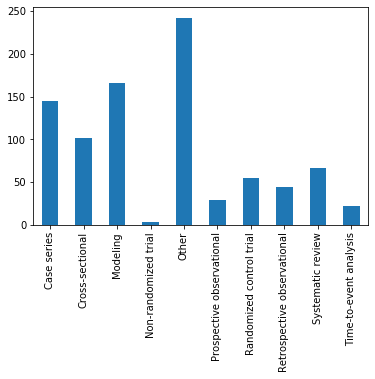

In [5]:
annotations_raw.label_string.value_counts().sort_index().plot.bar()

In [6]:
list(annotations_raw.label_string.unique())

['Other',
 'Systematic review',
 'Randomized control trial',
 'Non-randomized trial',
 'Prospective observational',
 'Time-to-event analysis',
 'Retrospective observational',
 'Cross-sectional',
 'Case series',
 'Modeling']

classification with catboost on annotations title + abstract, using text features

In [7]:
design_labelled_metadata = annotations_raw[['abstract', 'title', 'label']].sample(frac=1.0)
test_set_len = len(design_labelled_metadata) //5

In [8]:

results = []
params = {}
for i in tqdm(range(5)):
    test = design_labelled_metadata.iloc[i * test_set_len : (i+1)* test_set_len]
    test_classes =np.sort( test.label.unique())
    train = design_labelled_metadata[~design_labelled_metadata.index.isin(test.index)]
    model, acc, f1, f1_macro,confusion_matrix, params = train_validate_catboost_model(
        train, test,
        ['abstract', 'title'],
        'label',
        text_features=['abstract', 'title'], params={}, verbose=False)
    results.append({
        "i": i,
        "f1": {k: v for k, v in zip(test_classes, f1)},
        "acc": acc,
        'f1_macro': f1_macro,
        'confusion_matrix': confusion_matrix
    })

results = pd.DataFrame(results)
params_str = ",".join([f"{k}={v}" for k, v in params.items()])
print(pd.DataFrame(results))

  0%|          | 0/5 [00:00<?, ?it/s]2020-05-06 22:05:48,128::INFO::catboost_classifier.py::83  accuracy: 0.8114285714285714
2020-05-06 22:05:48,129::INFO::catboost_classifier.py::84  f1: [0.72897196 0.88888889 0.96296296 0.         0.66666667 0.66666667
 0.72727273 0.88235294 0.88       0.82051282]
2020-05-06 22:05:48,129::INFO::catboost_classifier.py::85  f1_macro: 0.7224295636764027
 20%|██        | 1/5 [00:11<00:44, 11.09s/it]2020-05-06 22:05:59,390::INFO::catboost_classifier.py::83  accuracy: 0.8342857142857143
2020-05-06 22:05:59,391::INFO::catboost_classifier.py::84  f1: [0.80392157 1.         0.96774194 0.66666667 0.22222222 0.8
 0.88372093 0.85185185 0.8       ]
2020-05-06 22:05:59,391::INFO::catboost_classifier.py::85  f1_macro: 0.777347241676069
 40%|████      | 2/5 [00:22<00:33, 11.14s/it]2020-05-06 22:06:10,199::INFO::catboost_classifier.py::83  accuracy: 0.8228571428571428
2020-05-06 22:06:10,200::INFO::catboost_classifier.py::84  f1: [0.76635514 1.         1.         0.8

   i                                                 f1       acc  f1_macro  \
0  0  {0: 0.7289719626168223, 1: 0.888888888888889, ...  0.811429  0.722430   
1  1  {0: 0.803921568627451, 1: 1.0, 2: 0.9677419354...  0.834286  0.777347   
2  2  {0: 0.7663551401869159, 1: 1.0, 2: 1.0, 4: 0.8...  0.822857  0.756739   
3  3  {0: 0.7407407407407407, 1: 0.9230769230769231,...  0.737143  0.597281   
4  4  {0: 0.8440366972477064, 1: 1.0, 2: 0.909090909...  0.834286  0.750519   

                                    confusion_matrix  
0  [[39.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...  
1  [[41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0...  
2  [[41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
3  [[40.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0...  
4  [[46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0...  


/home/wwymak/coronawhy/text_classification/classifier/plotting.py:59: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


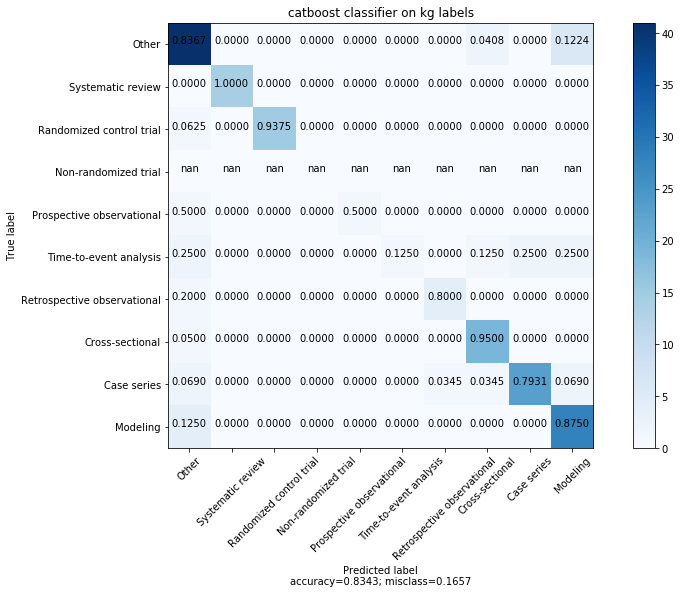

In [21]:
from plotting import plot_confusion_matrix
label_to_name_mapping = annotations_raw[['label', 'label_string']].drop_duplicates().set_index('label')
plot_confusion_matrix(results.iloc[1].confusion_matrix, target_names =[label_to_name_mapping.loc[x].label_string for x in sorted(annotations_raw.label.unique())] ,
                      title='catboost classifier on kg labels', figsize=(12,8))


In [19]:
# [x for label_to_name_mapping.loc[x] in sorted(annotations_raw.label.unique())]s
str(label_to_name_mapping.loc[1].label_string)

'Systematic review'

AS per https://github.com/catboost/tutorials/blob/2c16945f850503bfaa631176e87588bc5ce0ca1c/text_features/text_features_in_catboost.ipynb there are a lot of extra text processing params we can possibly tweak

In [28]:
extra_text_params={
        'dictionaries': [
            'Word:min_token_occurrence=2',
            'BiGram:gram_order=2',
            'UniGram:gram_order=1'
        ],
        'text_processing': [
            'BM25+Word|NaiveBayes+Word,BiGram|BoW:top_tokens_count=1000+Word,BiGram'
        ]
    }
boosting_params ={
#     'iterations': 2000,
#         'learning_rate': 0.005,
}
results_catboost2 = []
for i in tqdm(range(5)):
    test = design_labelled_metadata.iloc[i * test_set_len : (i+1)* test_set_len]
    test_classes =np.sort( test.label.unique())
    train = design_labelled_metadata[~design_labelled_metadata.index.isin(test.index)]
    model, acc, f1, f1_macro, params = train_validate_catboost_model(
        train, test,
        ['abstract', 'title'],
        'label',
        text_features=['abstract', 'title'], params={**extra_text_params, **boosting_params}, verbose=False)
    results_catboost2.append({
        "i": i,
        "f1": {k: v for k, v in zip(test_classes, f1)},
        "acc": acc,
        'f1_macro': f1_macro,
        "best_iteration": model.get_best_iteration()
    })

results_catboost2 = pd.DataFrame(results_catboost2)
pd.DataFrame(results_catboost2)

  0%|          | 0/5 [00:00<?, ?it/s]2020-05-02 21:44:51,110::INFO::catboost_classifier.py::81  accuracy: 0.7942857142857143
2020-05-02 21:44:51,110::INFO::catboost_classifier.py::82  f1: [0.73873874 0.92857143 1.         1.         0.5        0.4
 0.7        0.95       0.72413793 0.80645161]
2020-05-02 21:44:51,110::INFO::catboost_classifier.py::83  f1_macro: 0.7747899711247876
 20%|██        | 1/5 [00:10<00:40, 10.16s/it]2020-05-02 21:45:01,190::INFO::catboost_classifier.py::81  accuracy: 0.7714285714285715
2020-05-02 21:45:01,191::INFO::catboost_classifier.py::82  f1: [0.72527473 1.         1.         0.         0.6        0.6
 0.83333333 0.89361702 0.68852459 0.73684211]
2020-05-02 21:45:01,191::INFO::catboost_classifier.py::83  f1_macro: 0.7077591775311747
 40%|████      | 2/5 [00:20<00:30, 10.14s/it]2020-05-02 21:45:11,357::INFO::catboost_classifier.py::81  accuracy: 0.7828571428571428
2020-05-02 21:45:11,358::INFO::catboost_classifier.py::82  f1: [0.74782609 0.85714286 0.9285714

,i,f1,acc,f1_macro,best_iteration
0,0,"{0: 0.7387387387387387, 1: 0.9285714285714286,...",0.794286,0.774790,935
1,1,"{0: 0.7252747252747253, 1: 1.0, 2: 1.0, 3: 0.0...",0.771429,0.707759,831
2,2,"{0: 0.7478260869565216, 1: 0.8571428571428572,...",0.782857,0.680629,251
3,3,"{0: 0.7927927927927928, 1: 0.9285714285714286,...",0.811429,0.735886,340
4,4,"{0: 0.8141592920353983, 1: 1.0, 2: 0.941176470...",0.811429,0.704145,892


In [15]:
pd.DataFrame(results_catboost2.f1.to_list()).mean()

0    0.763758
1    0.942857
2    0.973950
3    0.333333
4    0.681818
5    0.300000
6    0.622424
7    0.938197
8    0.721178
9    0.778932
dtype: float64

note that not class 3 ("Non-randomized trial") has very few articles so we might consider removing them from training set

classification wiht annotations + umls-- actually, can't use just the selected sections...

In [9]:
annotations_with_umls = enrich_annotations(annotations_raw, processed_article_folder, extra_features=['UMLS'], sections=['method', 'result', 'abstract'])

100%|██████████| 20/20 [03:11<00:00,  9.59s/it]


In [17]:
# method_UMLS = annotations_with_umls.groupby('cord_uid')['method_UMLS'].fillna('').apply(','.join).reset_index()
# abstract_UMLS =  annotations_with_umls.groupby('cord_uid')['abstract_UMLS'].fillna('').apply(','.join).reset_index()
# result_UMLS =  annotations_with_umls.groupby('cord_uid')['result_UMLS'].fillna('').apply(','.join).reset_index()

In [10]:
annotations_with_umls['abstract_UMLS'] = annotations_with_umls['abstract_UMLS'].apply(lambda d: d if isinstance(d, list) else [])
annotations_with_umls['result_UMLS'] = annotations_with_umls['result_UMLS'].apply(lambda d: d if isinstance(d, list) else [])
annotations_with_umls['method_UMLS'] = annotations_with_umls['method_UMLS'].apply(lambda d: d if isinstance(d, list) else [])


annotations_with_umls.groupby('cord_uid')['method_UMLS'].sum().shape

(875,)

In [11]:
method_UMLS = annotations_with_umls.groupby('cord_uid')['method_UMLS'].sum().apply(','.join)
abstract_UMLS = annotations_with_umls.groupby('cord_uid')['abstract_UMLS'].sum().apply(','.join)
result_UMLS = annotations_with_umls.groupby('cord_uid')['result_UMLS'].sum().apply(','.join)

In [12]:
joblib.dump({'method_UMLS': method_UMLS, 'abstract_UMLS': abstract_UMLS, 'result_UMLS': result_UMLS}, data_dir/'annotations_w_umls.pkl', compress=3)

['/media/wwymak/Storage/coronawhy/nlp_datasets/annotations_w_umls.pkl']

In [ ]:
umls_dict = joblib.load(data_dir/'annotations_w_umls.pkl')

In [16]:
abstract_UMLS[abstract_UMLS.apply(lambda x: len(x)> 0)].head()

cord_uid
4pab383g    Patients,Ethics,Eligible,Patients,Fever,Signs ...
v8p4gjay    Publications,Research Methodology,Study Object...
Name: method_UMLS, dtype: object

In [19]:
result_UMLS[result_UMLS.apply(lambda x: len(x)> 0)].shape

(0,)

using other things -- lemmas and text from the articles in addition to title + abstract

In [14]:
annotations_with_lemmas  = enrich_annotations(annotations_raw, processed_article_folder, extra_features=['lemma'], sections=['method', 'result', 'abstract', 'summary', 'discussion'])





  0%|          | 0/20 [00:00<?, ?it/s]



  5%|▌         | 1/20 [00:12<03:58, 12.56s/it]



 10%|█         | 2/20 [00:30<04:16, 14.28s/it]



 15%|█▌        | 3/20 [00:40<03:40, 12.97s/it]



 20%|██        | 4/20 [00:55<03:38, 13.63s/it]



 25%|██▌       | 5/20 [01:09<03:25, 13.70s/it]



 30%|███       | 6/20 [01:44<04:39, 19.94s/it]



 35%|███▌      | 7/20 [02:06<04:29, 20.70s/it]



 40%|████      | 8/20 [02:20<03:42, 18.57s/it]



 45%|████▌     | 9/20 [02:36<03:15, 17.77s/it]



 50%|█████     | 10/20 [02:46<02:35, 15.54s/it]



 55%|█████▌    | 11/20 [02:58<02:10, 14.54s/it]



 60%|██████    | 12/20 [03:15<02:02, 15.26s/it]

ValueError: StringArray requires a sequence of strings or pandas.NA

using the specter embeddings + catboost

In [31]:
annotations_raw.shape
annotations_with_specter_df = annotations_with_specter_embeddings(annotations_raw,data_dir/ 'cord_19_specter_embeddings_4_17.csv.zip' )
annotations_with_specter_df.shape

(746, 774)

In [32]:
annotations_with_specter_df = annotations_with_specter_df[['abstract', 'title', 'label'] + [f"{i}" for i in range(768)]].sample(frac=1.0)
test_set_len = len(annotations_with_specter_df) //5
results = []
params = {}
for i in range(5):
    test = annotations_with_specter_df.iloc[i * test_set_len : (i+1)* test_set_len]
    train = annotations_with_specter_df[~annotations_with_specter_df.index.isin(test.index)]
    model, acc, f1, f1_macro, params = train_validate_catboost_model(
        train, test,
        [f"{i}" for i in range(768)],
        'label', text_features=None, params={}, verbose=False)
    results.append({
        "i": i,
        "f1": f1,
        "acc": acc,
        'f1_macro': f1_macro,
    })

results = pd.DataFrame(results)
params_str = ",".join([f"{k}={v}" for k, v in params.items()])
print(pd.DataFrame(results))

2020-04-27 22:25:00,632::INFO::catboost_classifier.py::43  accuracy: 0.6711409395973155
2020-04-27 22:25:00,633::INFO::catboost_classifier.py::44  f1: [0.51612903 0.81481481 0.83333333 0.         0.33333333 0.
 0.55555556 0.80851064 0.83333333 0.71428571 0.67605634]
2020-04-27 22:25:00,633::INFO::catboost_classifier.py::45  f1_macro: 0.5532138266581992
2020-04-27 22:25:20,988::INFO::catboost_classifier.py::43  accuracy: 0.6174496644295302
2020-04-27 22:25:20,988::INFO::catboost_classifier.py::44  f1: [0.47368421 0.83333333 0.875      0.58823529 0.         0.42857143
 0.77777778 0.5        0.46153846 0.61702128]
2020-04-27 22:25:20,988::INFO::catboost_classifier.py::45  f1_macro: 0.5555161782460709
2020-04-27 22:25:41,518::INFO::catboost_classifier.py::43  accuracy: 0.6174496644295302
2020-04-27 22:25:41,518::INFO::catboost_classifier.py::44  f1: [0.57894737 0.8        0.82758621 0.         0.26666667 0.14285714
 0.38095238 0.73913043 0.8        0.59459459 0.64516129]
2020-04-27 22:25:4

   i                                                 f1       acc  f1_macro
0  0  [0.5161290322580646, 0.8148148148148148, 0.833...  0.671141  0.553214
1  1  [0.47368421052631576, 0.8333333333333333, 0.87...  0.617450  0.555516
2  2  [0.5789473684210527, 0.8, 0.8275862068965517, ...  0.617450  0.525081
3  3  [0.38461538461538464, 0.7368421052631577, 0.87...  0.651007  0.591311
4  4  [0.4, 0.8648648648648649, 0.8333333333333334, ...  0.637584  0.537067


In [30]:
pd.DataFrame(results)

,i,f1,acc,f1_macro
0,0,"[0.3571428571428571, 0.9375, 0.909090909090909...",0.651007,0.593818
1,1,"[0.4571428571428571, 0.7999999999999999, 0.823...",0.604027,0.506118
2,2,"[0.4666666666666667, 0.6666666666666667, 0.869...",0.657718,0.566968
3,3,"[0.3636363636363636, 0.8666666666666667, 0.75,...",0.671141,0.570249
4,4,"[0.48275862068965514, 0.888888888888889, 0.882...",0.610738,0.567772


In [30]:
# train final model

final_model = train_validate_catboost_model(
        design_labelled_metadata, None,
        ['abstract', 'title'],
        'label',
        text_features=['abstract', 'title'], params={'iterations': 400}, verbose=False)

In [31]:
final_model.save_model(str(data_dir/'catboost_david_annotation_2_may'))